## Test New CODE

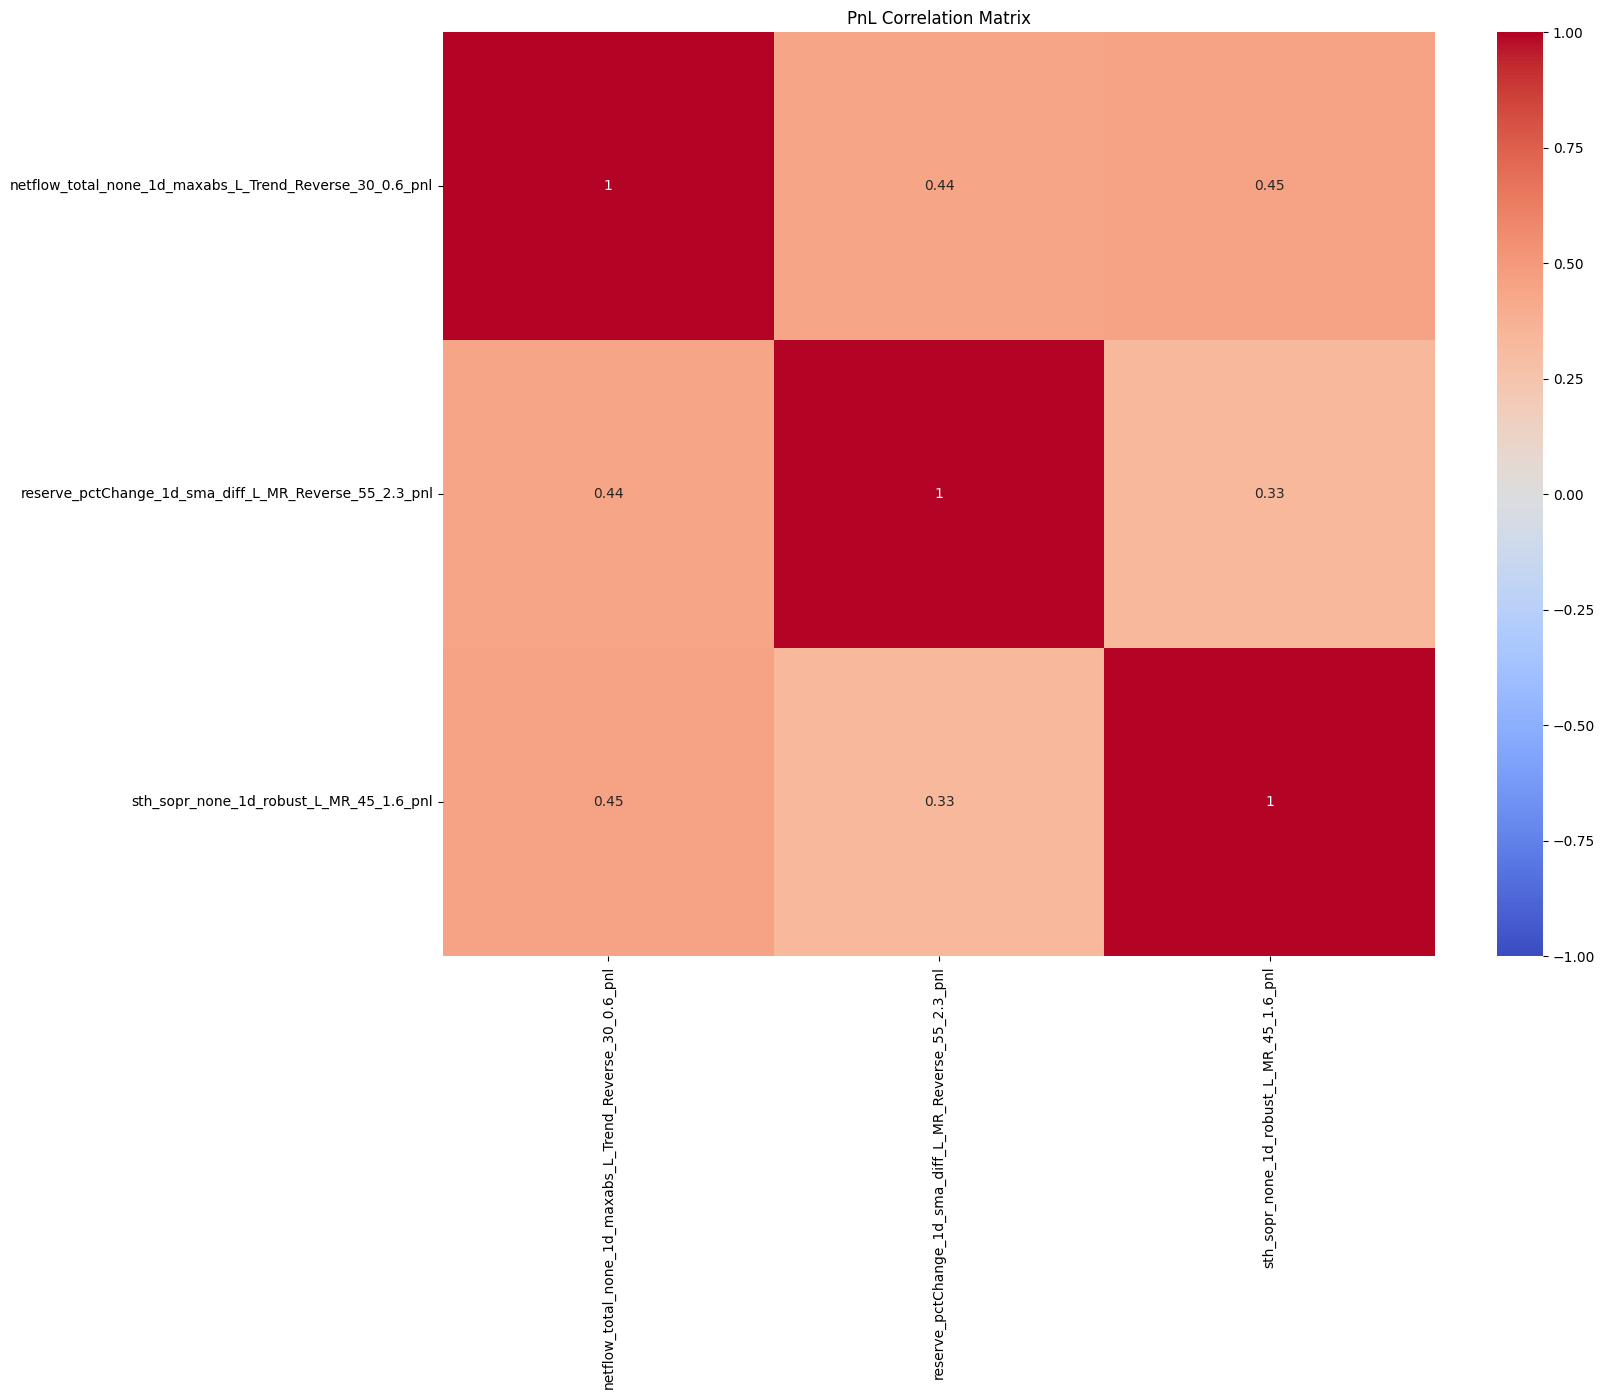

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def read_and_preprocess_csv(file_path: str) -> pd.DataFrame:
    """
    讀取單一 CSV，將 start_time 轉為 datetime 並設為索引。
    同時自動判斷是否需要將高頻資料 (1H, 4H 等) 聚合為日頻。
    
    回傳只包含 'pnl' 和 'drawdown' 兩欄（已聚合至日頻）。
    - pnl 以 sum 方式聚合 (假設是金額)
    - drawdown 以 min 方式聚合 (因為回撤越小越嚴重)
    """
    df = pd.read_csv(file_path)
    
    # 1) 轉為 datetime，假設 start_time 是毫秒級 (unit='ms')
    df['start_time'] = pd.to_datetime(df['start_time'], unit='ms')
    
    # 2) 設為索引並排序
    df.set_index('start_time', inplace=True)
    df.sort_index(inplace=True)
    
    # 確認是否有 'pnl' 與 'drawdown' 欄位
    for col in ['pnl', 'drawdown']:
        if col not in df.columns:
            raise ValueError(f"'{col}' column not found in {file_path}")

    # 3) 若資料頻率小於日 (例如 1H、4H)，則聚合至日頻
    if len(df) > 1:
        median_diff = df.index.to_series().diff().median()
        if median_diff < pd.Timedelta(hours=23):
            df = df.resample('D').agg({
                'pnl': 'sum',        # 假設 'pnl' 是金額 => 加總
                'drawdown': 'min',   # 'drawdown' 越小越嚴重 => 取 min
            })
    
    # 4) 回傳僅包含 'pnl' & 'drawdown'
    return df[['pnl', 'drawdown']]

# --------------------------------------
# 讀取整個資料夾並合併到兩個 DataFrame
# --------------------------------------
folder_path = './excel_for_each_backtest'  # 你的資料夾路徑
combined_pnl = pd.DataFrame()
combined_dd = pd.DataFrame()

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        
        # 讀取並處理單一檔案 (聚合為日頻)
        df_agg = read_and_preprocess_csv(file_path)
        
        # 以檔名 (去除副檔名) 作為策略名稱
        strategy_name = os.path.splitext(file)[0]
        
        # 重新命名欄位，避免不同策略合併時覆蓋
        # 例：pnl -> <strategy_name>_pnl, drawdown -> <strategy_name>_dd
        df_agg.rename(columns={
            'pnl': f'{strategy_name}_pnl',
            'drawdown': f'{strategy_name}_dd'
        }, inplace=True)
        
        # 合併到 combined_pnl 與 combined_dd
        combined_pnl = pd.concat([combined_pnl, df_agg[f'{strategy_name}_pnl']], axis=1)
        combined_dd = pd.concat([combined_dd, df_agg[f'{strategy_name}_dd']], axis=1)

# 確保合併後的索引有序
combined_pnl.sort_index(inplace=True)
combined_dd.sort_index(inplace=True)

# (示例) 檢視最後的 DataFrame
# print("=== combined_pnl head ===")
# print(combined_pnl.head())
# print("=== combined_dd head ===")
# print(combined_dd.head())

# (範例) 只針對 PnL 做相關係數矩陣並繪圖
correlation_matrix = combined_pnl.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('PnL Correlation Matrix')
plt.show()


Average 6-month Rolling Sharpe Ratio: 2.203003303088538
✓ Portfolio meets the 6-month rolling SR requirement (> 2.2).

Portfolio MDD (via aggregated daily drawdown): -0.356670062989352
✓ MDD is within the limit (> -40%).

Total Portfolio PnL: 2.793523102659724
Portfolio Sharpe Ratio (non-rolling): 2.27001278257966


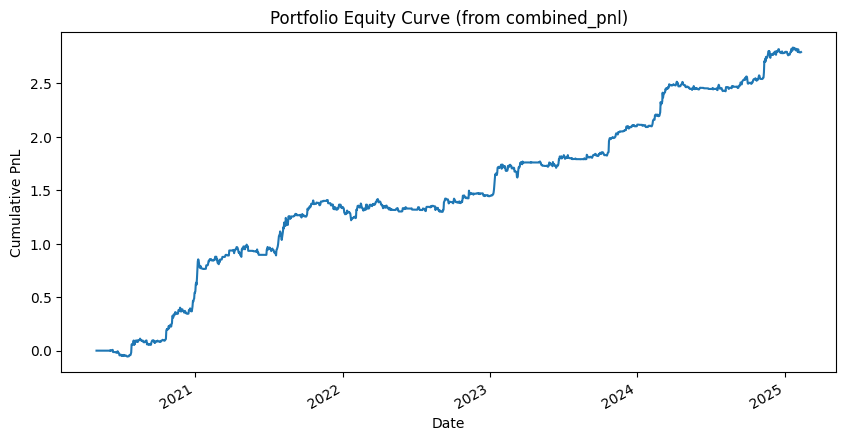

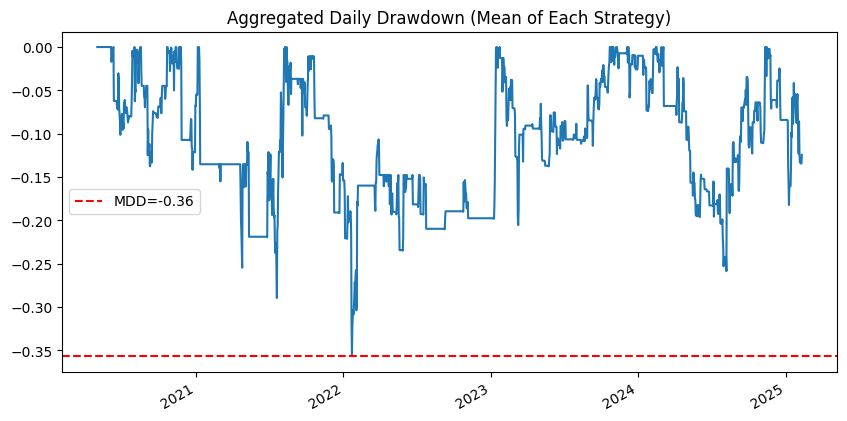

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_rolling_sharpe_ratio(daily_pnl: pd.Series, window: int = 180) -> pd.Series:
    """
    計算日損益序列在指定滾動視窗下的 Sharpe Ratio（年化）。
    Sharpe Ratio = (平均日收益 / 日收益標準差) * sqrt(365)
    
    :param daily_pnl: Pandas Series，索引為日期，值為日損益或日收益。
    :param window: 滾動視窗的大小（天數），例如 180 代表約 6 個月。
    :return: Pandas Series，對應日期的滾動 Sharpe Ratio。
    """
    rolling_mean = daily_pnl.rolling(window=window).mean()
    rolling_std = daily_pnl.rolling(window=window).std()
    rolling_sharpe = (rolling_mean / rolling_std) * np.sqrt(365)
    return rolling_sharpe

def calculate_sharpe_ratio(daily_pnl: pd.Series) -> float:
    """
    計算非滾動 Sharpe Ratio（年化）。
    Sharpe Ratio = (平均日收益 / 日收益標準差) * sqrt(365)
    
    :param daily_pnl: Pandas Series，索引為日期，值為日損益或日收益。
    :return: 一個浮點數，代表整段期間的 Sharpe Ratio。
    """
    mean_return = daily_pnl.mean()
    std_return = daily_pnl.std()
    if std_return == 0:
        return np.nan
    return (mean_return / std_return) * np.sqrt(365)

def calculate_max_drawdown(equity_curve: pd.Series) -> float:
    rolling_max = equity_curve.cummax()
    dd_series = (equity_curve - rolling_max)
    return dd_series.min()

def calc_daily_drawdown(equity_curve: pd.Series) -> pd.Series:
    """
    計算 equity_curve 每天的相對回撤：
    drawdown(t) = (equity(t) - max_equity(從開頭到t))
    """
    rolling_max = equity_curve.cummax()
    daily_dd = (equity_curve - rolling_max)
    return daily_dd

# --------------------------------
# (B) 標準計算：先合併 PnL 再算 Equity Curve
# --------------------------------
# 1) 假設投資組合的日損益 = 多策略平均
portfolio_daily_pnl = combined_pnl.mean(axis=1)

# 2) 計算 Sharpe
rolling_sr_series = calculate_rolling_sharpe_ratio(portfolio_daily_pnl, window=180)

average_rolling_sr = rolling_sr_series.mean()
print("Average 6-month Rolling Sharpe Ratio:", average_rolling_sr)

if average_rolling_sr > 2.2:
    print("✓ Portfolio meets the 6-month rolling SR requirement (> 2.2).\n")
else:
    print("✗ Portfolio does NOT meet the 6-month rolling SR requirement.\n")

# **繪製滾動 Sharpe Ratio 圖表**
plt.figure(figsize=(12, 6))
rolling_sr_series.plot(color='b', label="6-Month Rolling Sharpe Ratio")
plt.axhline(2.2, color='r', linestyle='--', label="Threshold (2.2)")

# 標註數值
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.title("6-Month Rolling Sharpe Ratio Over Time")
plt.legend()
plt.show()

# 3) Portfolio MDD (由累計損益計算)
portfolio_equity_curve = portfolio_daily_pnl.cumsum()

shifted_equity_curve = portfolio_equity_curve + 1.0
portfolio_mdd_dd_method = calculate_max_drawdown(shifted_equity_curve)
print("\nPortfolio MDD (via aggregated daily drawdown):", portfolio_mdd_dd_method)

if portfolio_mdd_dd_method > -0.40:
    print("✓ MDD is within the limit (> -40%).\n")
else:
    print("✗ MDD exceeds the limit (<= -40%).\n")

portfolio_daily_dd = calc_daily_drawdown(shifted_equity_curve)

# 4) 其他 Metrics
total_portfolio_pnl = portfolio_daily_pnl.sum()
print("Total Portfolio PnL:", total_portfolio_pnl)

portfolio_sharpe = calculate_sharpe_ratio(portfolio_daily_pnl)
print("Portfolio Sharpe Ratio (non-rolling):", portfolio_sharpe)

# 繪製投資組合 Equity Curve
plt.figure(figsize=(10, 5))
portfolio_equity_curve.plot(title="Portfolio Equity Curve (from combined_pnl)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.show()

# 也可繪製「合成 drawdown」時間序列
plt.figure(figsize=(10, 5))
portfolio_daily_dd.plot(title="Aggregated Daily Drawdown (Portfolio Drawdown)")
plt.axhline(portfolio_mdd_dd_method, color='r', linestyle='--', 
            label=f"MDD={portfolio_mdd_dd_method:.2f}")
plt.legend()
plt.show()
